# Premières mises en formes et visualisations

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat

## Import des bases

In [2]:
 df_2020 = pd.read_csv('valeursfoncieres-2020.txt', sep="|", decimal=',')

C:\Users\olivier\anaconda\envs\Geo\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (14,18,23,24,26,28,41) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#df_2020.head()

## Premiers filtres

On filtre sur les ventes d'appartements et de maisons uniquement via la variable "Type local".

In [4]:
df = df_2020[(df_2020["Type local"] == "Appartement") | (df_2020["Type local"] == "Maison")]
df = df[df["Nature mutation"]=="Vente"]

On enlève les lignes doublons.

In [5]:
df.drop_duplicates(subset = None, inplace = True)

On enlève les premières colonnes non nécéssaires au début (ils sont remplis en NaN)

In [6]:
df.drop(["Code service CH","Reference document","1 Articles CGI",
              "2 Articles CGI","3 Articles CGI","4 Articles CGI",
              "5 Articles CGI"],axis = 1, inplace=True)

On remarque que certaines lignes qui partagent la même date de signature (Date mutation), le même prix de vente (Valeur fonciere), ainsi que le même code postal (Code postal) ressortent en doublons (divisions d'un lot en plusieurs).

Nous décidons de les retirer dans un premier temps car nous avons pas le détails au cas par cas et ils ne représentent qu'une petite partie (environ 18%) de la base mais influence grandement la variable cible.

In [7]:
(df.duplicated(subset = ["Date mutation","Valeur fonciere","Code postal"]).sum()/df.shape[0])*100

18.502652554317837

In [8]:
df = df.drop_duplicates(subset = ["Date mutation","Valeur fonciere","Code postal"], keep = False)

## Gestion des outliers 

In [8]:
df["Valeur fonciere"].describe()

count    8.825000e+05
mean     4.334537e+05
std      4.533277e+06
min      1.500000e-01
25%      1.100000e+05
50%      1.790000e+05
75%      2.900000e+05
max      4.352450e+08
Name: Valeur fonciere, dtype: float64

Avec les infos précédentes, nous decidons d'enlever les maisons/appartements aux prix trop bas ou trop élevés car ils peuvent être considérés comme exceptionnels.

In [10]:
outliers_max = df["Valeur fonciere"].quantile(0.98)
print("On ne garde que les biens vendus en dessous de : ",outliers_max," euros.")
outliers_min = df["Valeur fonciere"].quantile(0.01)
print("De même, on ne garde que les biens vendus au dessus de : ",outliers_min," euros.")
df_clean = df[(df["Valeur fonciere"] < outliers_max) & (df["Valeur fonciere"] > outliers_min) ]
print("Le data frame filter se nomme 'df_clean'")
print('La base de données est de taille', df_clean.shape)

On ne garde que les biens vendus en dessous de :  1250000.0  euros.
De même, on ne garde que les biens vendus au dessus de :  16000.0  euros.
Le data frame filter se nomme 'df_clean'
La base de données est de taille (855741, 36)


In [11]:
df_clean.columns

Index(['No disposition', 'Date mutation', 'Nature mutation', 'Valeur fonciere',
       'No voie', 'B/T/Q', 'Type de voie', 'Code voie', 'Voie', 'Code postal',
       'Commune', 'Code departement', 'Code commune', 'Prefixe de section',
       'Section', 'No plan', 'No Volume', '1er lot',
       'Surface Carrez du 1er lot', '2eme lot', 'Surface Carrez du 2eme lot',
       '3eme lot', 'Surface Carrez du 3eme lot', '4eme lot',
       'Surface Carrez du 4eme lot', '5eme lot', 'Surface Carrez du 5eme lot',
       'Nombre de lots', 'Code type local', 'Type local', 'Identifiant local',
       'Surface reelle bati', 'Nombre pieces principales', 'Nature culture',
       'Nature culture speciale', 'Surface terrain'],
      dtype='object')

## Visualisations

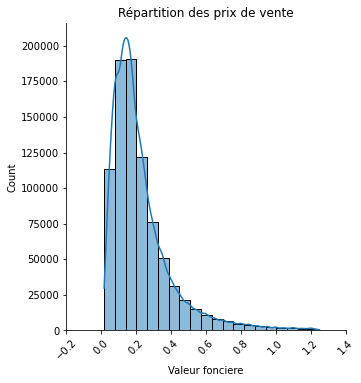

In [12]:
a= sns.displot(x= "Valeur fonciere", data = df_clean,
               bins = 20, kde = True).set(title = 'Répartition des prix de vente')
a.set_xticklabels(rotation=45);

Les prix de vente laissent présager un comportement gaussien. Testons cette hypothèse avec le test d'Agostino.

In [13]:
ag = stat.normaltest(df_clean["Valeur fonciere"]) # message d’avertissement, n est trop faible pour un test fiable
print(ag) 

NormaltestResult(statistic=378285.5304827426, pvalue=0.0)


Le résultat de la p-value ne nous permettent pas de rejetter la normalité.

Qu'en est-il de la répartition suivant le type de biens?

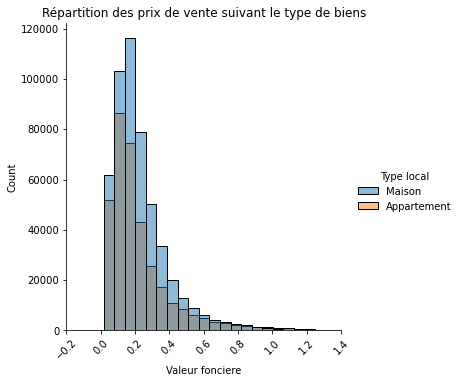

In [14]:
a= sns.displot(x= "Valeur fonciere", data = df_clean, hue = "Type local",
               bins = 20).set(title = 'Répartition des prix de vente suivant le type de biens')
a.set_xticklabels(rotation=45);

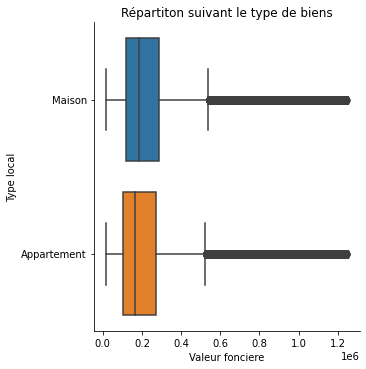

In [15]:
sns.catplot(x="Valeur fonciere", y = "Type local",kind="box",
            data=df_clean).set(title = 'Répartiton suivant le type de biens');

Analyse : 

- le prix de vente laisse penser à un comportement gaussien dans les deux cas (maison et appartement)
- la moyenne des prix des maisons est plus élevée que pour les appartements
- ainsi qu'une plus grande variablité
- une queue de distribution plus épaisse dans les deux cas à droite

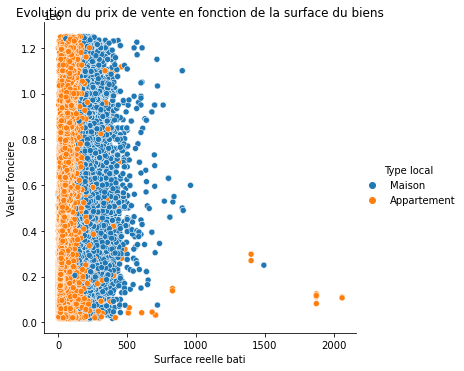

In [16]:
sns.relplot(x="Surface reelle bati", y="Valeur fonciere", 
            hue = 'Type local', data=df_clean).set(title = "Evolution du prix de vente en fonction de la surface du biens");

Analyse :
- nous ne distinguons pas grand chose car il semble avoir des valeurs aberrantes en surface
    
    

Et concernant les plus grandes villes de France (hors Paris, Marseille et Lyon - besoin de gérer les arrondissements)

In [17]:
Top_villes = df_clean[(df_clean["Commune"]=="PARIS"  )  | 
                      (df_clean["Commune"]=="MARSEILLE" )   |
                      (df_clean["Commune"]=="LYON"   ) |
                      (df_clean["Commune"]=="TOULOUSE" )   |
                      (df_clean["Commune"]=="NICE" )   |
                      (df_clean["Commune"]=="NANTES")    |
                      (df_clean["Commune"]=="MONTPELLIER")    |
                      (df_clean["Commune"]=="STRASBOURG" )   |
                      (df_clean["Commune"]=="BORDEAUX"   ) |
                      (df_clean["Commune"]=="LILLE" )   ]

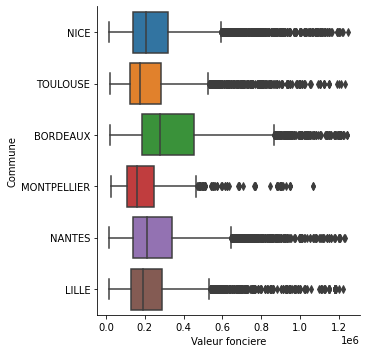

In [18]:
sns.catplot(x="Valeur fonciere", y = "Commune",kind="box", data=Top_villes);

Concernant Paris

In [19]:
Paris = df_clean[(df_clean["Commune"]=="PARIS 01"  )  | 
                      (df_clean["Commune"]=="PARIS 02" )   |
                      (df_clean["Commune"]=="PARIS 03"   ) |
                      (df_clean["Commune"]=="PARIS 04" )   |
                      (df_clean["Commune"]=="PARIS 05" )   |
                      (df_clean["Commune"]=="PARIS 06")    |
                      (df_clean["Commune"]=="PARIS 07")    |
                      (df_clean["Commune"]=="PARIS 08" )   |
                      (df_clean["Commune"]=="PARIS 09"   ) |
                      (df_clean["Commune"]=="PARIS 10"   ) |
                      (df_clean["Commune"]=="PARIS 11"   ) |
                      (df_clean["Commune"]=="PARIS 12"   ) |
                      (df_clean["Commune"]=="PARIS 13"   ) |
                      (df_clean["Commune"]=="PARIS 14"   ) |
                      (df_clean["Commune"]=="PARIS 15"   ) |
                      (df_clean["Commune"]=="PARIS 16"   ) |
                      (df_clean["Commune"]=="PARIS 17"   ) |
                      (df_clean["Commune"]=="PARIS 18"   ) |
                      (df_clean["Commune"]=="PARIS 19"   ) |
                      (df_clean["Commune"]=="PARIS 20" )   ]

In [20]:
Paris.groupby("Commune").agg(np.mean)["Valeur fonciere"].sort_values(ascending = False)

Commune
PARIS 16    591460.960205
PARIS 06    566925.525901
PARIS 07    566685.894235
PARIS 04    550675.243750
PARIS 08    547959.272243
PARIS 01    516239.967292
PARIS 03    510420.663175
PARIS 09    509450.806993
PARIS 15    501381.107965
PARIS 17    498038.631453
PARIS 05    497611.646343
PARIS 14    479519.843565
PARIS 10    475628.943566
PARIS 02    453860.486823
PARIS 12    452648.564200
PARIS 11    446949.950944
PARIS 13    437583.141129
PARIS 18    422243.425469
PARIS 20    416304.498080
PARIS 19    412680.130128
Name: Valeur fonciere, dtype: float64

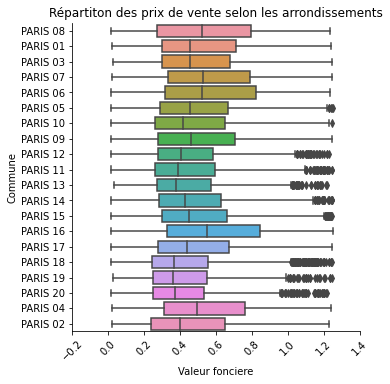

In [21]:
c = sns.catplot(x="Valeur fonciere", y = "Commune",kind="box", 
            data = Paris ).set(title='Répartiton des prix de vente selon les arrondissements')
c.set_xticklabels(rotation=45);

On ajoute les régions via le code département

In [22]:
regions = pd.read_csv("departements-region.csv")
regions.head(10)


FileNotFoundError: [Errno 2] No such file or directory: 'departements-region.csv'

In [ ]:
cor = df_clean.corr()

NameError: name 'cor' is not defined

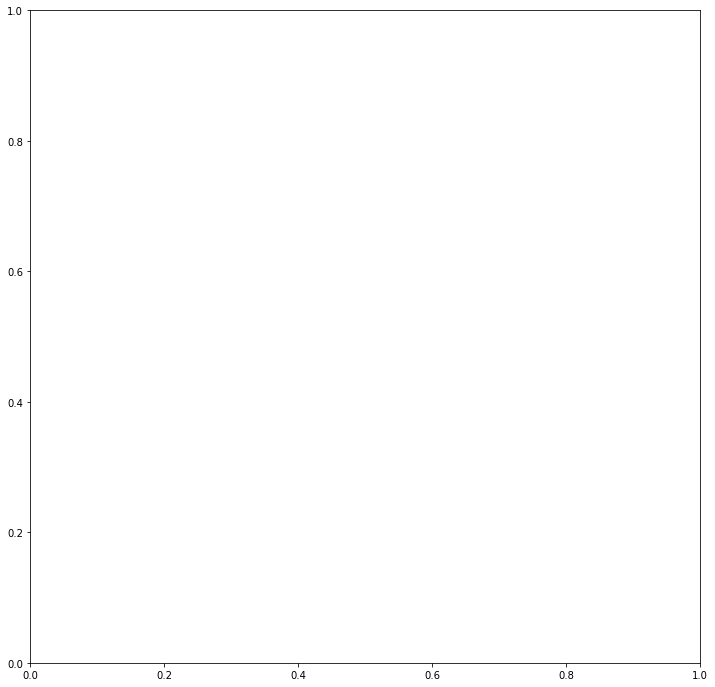

In [23]:
fig,ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot= True,ax=ax, cmap="coolwarm");

La surface réelle du biens, le nombre de pièces, ainsi que les surfaces Carrez des différents lots semblent corrélées avec la valeur foncière. 